###### The latest version of this IPython notebook is available at [http://github.com/jckantor](http://github.com/jckantor)  for noncommercial use under terms of the [Creative Commons Attribution Noncommericial ShareAlike License](http://creativecommons.org/licenses/by-nc-sa/4.0/).

Jeffrey C. Kantor (Kantor.1@nd.edu)

# Antoine's Equation and Database

The purpose of this notebook is to demonstrate the use Antoine's equation for routine chemical calcualtions. The notebook uses Google Sheets as a data repository of coefficients for Antoine parameters for a selected set of chemical species.

#### Table of Contents

* [Introduction to Antoine's Equation](#Introduction-to-Antoine's-Equation)
* [Calculating Saturation Pressure](#Calculating-Saturation-Pressure)
* [Plotting Saturation Pressure](#Plotting-Saturation-Pressure)
* [Calculating Saturation Temperature](#Calculating-Saturation-Temperature)
* [Specific Humidity](#Specific-Humidity)

#### How to Run this Notebook

You can open run this notebook directly by clicking on 

[![Binder](http://mybinder.org/badge.svg)](http://mybinder.org/repo/jckantor/Antoine-Database)

then selecting `Run All` under the Jupyter `Cell` menu. Alternatively, if you have access to a Jupyter development environment (such as [Anaconda](https://www.continuum.io/downloads)), you can download this notebook using `Download as ...` under the Jupyter `File` menu, or fork the entire project from the [github repository](https://github.com/jckantor/Antoine-Database).

## Introduction to Antoine's Equation

In [91]:
from IPython.display import YouTubeVideo
YouTubeVideo('VuiTiNP7QsU') 

Antoine's equation is used to estimate the pressure of the vapor phase of a pure component in equilibrium its pure liquid phase as a function of temperature. The form of the equation is

$$\log_{10} P^{sat}(T) = A - \frac{B}{T+C}$$

where $A$, $B$, and $C$ are constants specific to the species of interest. A data set of coefficients been prepared as a [Google Sheet](https://docs.google.com/spreadsheets/d/1lqIWdnmjiZX2LwHZ_5TdPXDOEn8hp-ZkdONlbjA-P1k/edit?usp=sharing) and read in the notebook by running the following cell.

In [84]:
import requests
from StringIO import StringIO
import pandas as pd

r = requests.get('https://docs.google.com/spreadsheets/d/' \
                 + '1lqIWdnmjiZX2LwHZ_5TdPXDOEn8hp-ZkdONlbjA-P1k' \
                 + '/export?format=csv&id')

csv = pd.io.parsers.read_csv(StringIO(r.content))

idx = pd.MultiIndex.from_tuples(zip(csv['Species'].str.lower(),csv['Tmin'],csv['Tmax']),
                         names=['Species','Tmin','Tmax'])

adb = pd.DataFrame(index = idx)
for v in ['A','B','C']:
    adb[v] = pd.Series(list(csv[v]),index = idx)

adb

A         B        C
Species      Tmin  Tmax                            
acetaldehyde -45.0 70    8.00550  1600.000  291.800
acetic acid   16.7 320   7.38782  1533.313  222.309
acetone      -94.3 235   7.02447  1161.000  224.000
benzene       8.0  103   6.90565  1211.033  220.790
ethanol      -2.0  100   8.04494  1554.300  222.650
methanol     -14.0 65    7.89750  1474.080  229.130
              65.0 110   7.97328  1515.140  232.850
toluene       6.0  137   6.95464  1344.800  218.480
water         0.0  60    8.10765  1750.286  235.000
              60.0 150   7.96681  1668.210  228.000

## Calculating Saturation Pressure

In [75]:
import numpy as np

def Psat(species,T):
    if isinstance(T,np.ndarray):
        return [Psat(species,t) for t in T]
    for Tmin,Tmax in adb.ix[species.lower()].index:
        if (T >= Tmin) & (T <= Tmax):
            A = adb.ix[species.lower(),Tmin,Tmax]['A']
            B = adb.ix[species.lower(),Tmin,Tmax]['B']
            C = adb.ix[species.lower(),Tmin,Tmax]['C']
            return 10.0**(A - B/(T + C) )
    else:
        return float('nan')

#### Example
_What is the saturation pressure of water at 100 deg. C?_

In [76]:
species = 'water'
T = 100.0

print 'Saturation pressure of', species, 
print 'at', T, 'deg C =', 
print Psat(species,T), 'mmHg'

Saturation pressure of water at 100.0 deg C = 759.983043308 mmHg


#### Example
_What is the highest altitude a human can travel before blood boils at normal body temperature (37 deg. C)?_

This is known as the [Armstrong Limit](https://en.wikipedia.org/wiki/Armstrong_limit). The saturation pressure of water at 37 deg. C is computed as follows.

In [77]:
species = 'water'
T = 37.0
print 'Saturation pressure of', species, 
print 'at', T, 'deg C =', 
print Psat(species,T), 'mmHg'

Saturation pressure of water at 37.0 deg C = 47.0733384885 mmHg


Consulting standard tables for air pressure as a function of altitude, we see a pressure of 47 mmHg corresponds to an altitude of about 62,000 ft above sea level.

## Plotting Saturation Pressure

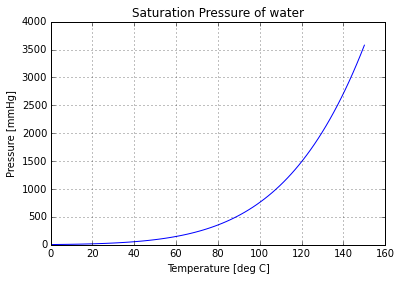

In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

def PsatPlot(species):
    for Tmin,Tmax in adb.ix[species].index:
        T = np.linspace(Tmin,Tmax)
        plt.plot(T,Psat(species,T),'b')
    plt.xlabel('Temperature [deg C]')
    plt.ylabel('Pressure [mmHg]')
    plt.title('Saturation Pressure of ' + species)
    plt.grid();
    
PsatPlot('water')

### Interactive Widget for Plotting Saturation Pressure

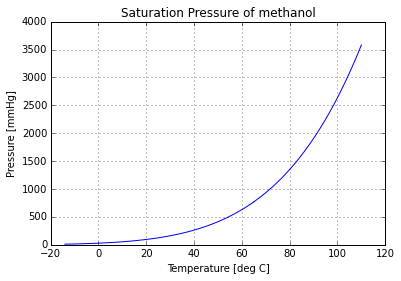

In [79]:
import ipywidgets as widgets
from IPython.display import display

widgets.interact(PsatPlot, species=list(adb.index.levels[0]));

## Calculating Saturation Temperature

In [80]:
from scipy.optimize import brentq

def Tsat(species,P):
    if isinstance(P,np.ndarray):
        return [Tsat(species,p) for p in P]
    Ta = 1000.0
    Tb = -273.15
    for Tmin,Tmax in adb.ix[species.lower()].index:
        Ta = min(Ta,Tmin)
        Tb = max(Tb,Tmax)
    f = 
    try:
        return brentq(lambda T: Psat(species,T) - P,Ta,Tb)
    except:
        return float('nan')

#### Create a Table of Normal Boiling Points

The normal boiling point of a liquid is the temperature at which the vapor pressure is equal to one atmosphere.

In [81]:
P = 760.0
species = list(adb.index.levels[0])

print "Normal Boiling Points in Deg C."
for s in species:
    print '{0:15s}'.format(s),
    print '{0:6.1f}'.format(Tsat(s,P))

Normal Boiling Points in Deg C.
acetaldehyde      20.4
acetic acid      117.9
acetone           56.2
benzene           80.1
ethanol           78.3
methanol          64.7
toluene          111.6
water            100.0


## Specific Humidity

For a given mass of moist air $m_{air}$, specific humidity is the ratio of the mass of water vapor $m_w$ to the mass of dry air $m_{dry\ air}$. 

$$SH = \frac{m_w}{m_{dry\ air}}$$

From Dalton's law, the mole fraction of a species in an ideal gas is proportional to it's partial pressure. $M_{w} = 18.01$ is the molar mass of water, and $M_{air} = 28.97$ is the molar mass of air. This gives

$$SH = \frac{M_w P_w}{M_{air} (P_T - P_w)}$$

where $P_w$ is the partial pressure of water in the moist air, and $P_T$ is total moist air pressure. The maximum specific humidity occurs when $P_w = P^{sat}_w(T)$ which gives us a simple formula

$$SH_{max} = \frac{M_w}{M_{air}} \frac{P^{sat}_w(T)}{(P_T - P^{sat}_w(T))}$$

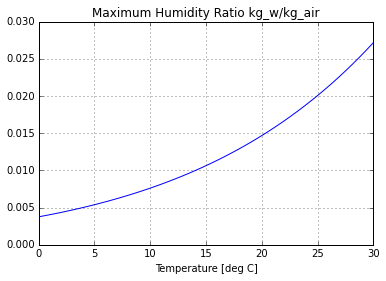

In [89]:
T = np.linspace(0.0,30.0)
Mw = 18.01
Ma = 28.97
P = 760.0

def SH(T):
    return Mw*Psat('water',T)/(Ma*(P-Psat('water',T)))

plt.plot(T, map(SH,T))
plt.title('Maximum Humidity Ratio kg_w/kg_air')
plt.xlabel('Temperature [deg C]')
plt.grid()